# Script to preprocess the data in order to use it for machine learning

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [30]:
# Define area of interest (AOI)
AOI = [90, 130, -10, 15] # Malaysia

In [31]:
# Import data
grav = np.load("../data/raw/grav.npy")
ship = np.load("../data/raw/ship.npy")
topo_low = np.load("../data/raw/topo_low.npy")
lat = np.load("../data/raw/lat.npy")
lon = np.load("../data/raw/lon.npy")

In [32]:
# Save prediction dataset
prediction_dataset = (np.array([lon, lat, grav, topo_low]).reshape(4, -1)).T
np.save("../data/processed/prediction.npy", prediction_dataset)

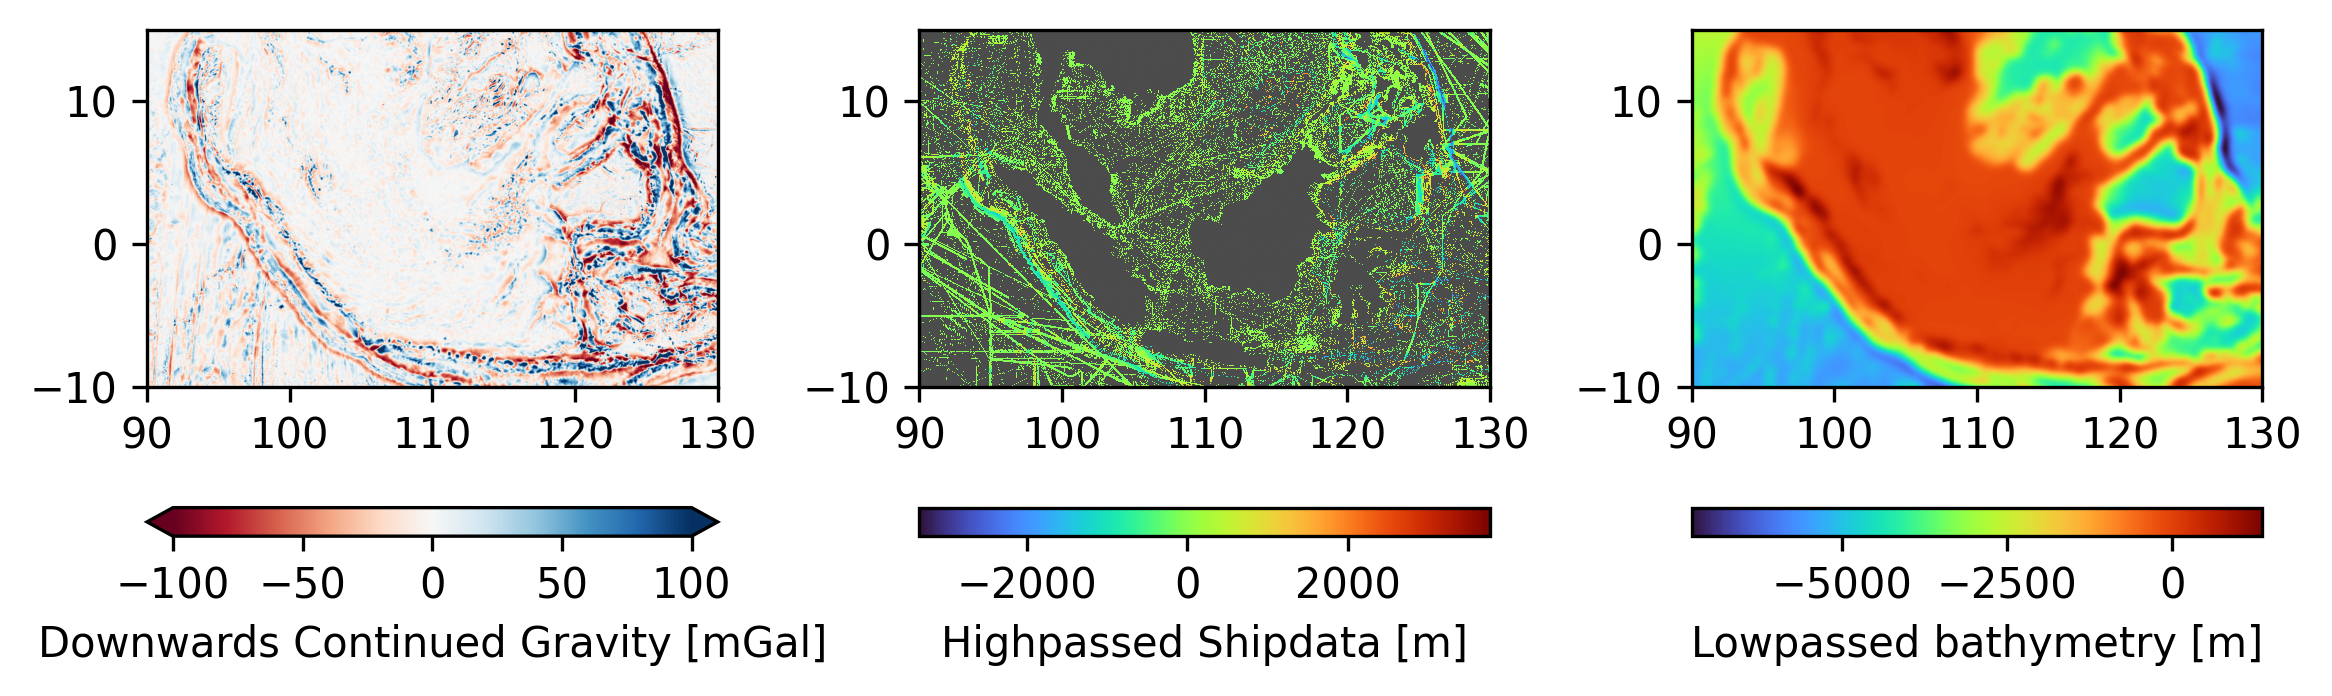

In [33]:
cm = 1/2.54
fig = plt.figure(figsize=(20*cm, 8*cm), dpi=300)

ax = fig.add_subplot(1,3,1)
sc=ax.imshow(grav, extent=AOI, origin="lower", vmin=-100, vmax=100, cmap="RdBu")
plt.colorbar(sc, orientation="horizontal", label="Downwards Continued Gravity [mGal]", extend="both")

ax = fig.add_subplot(1,3,2)
sc=ax.imshow(np.zeros_like(grav)+0.3, extent=AOI, cmap="gray", vmin=0, vmax=1)
sc=ax.imshow(ship, extent=AOI, origin="lower", cmap="turbo", interpolation="none")
plt.colorbar(sc, orientation="horizontal", label="Highpassed Shipdata [m]")

ax = fig.add_subplot(1,3,3)
sc=ax.imshow(topo_low, extent=AOI, origin="lower", cmap="turbo")
plt.colorbar(sc, orientation="horizontal", label="Lowpassed bathymetry [m]")

plt.tight_layout()
plt.show()

N valid data: 835855


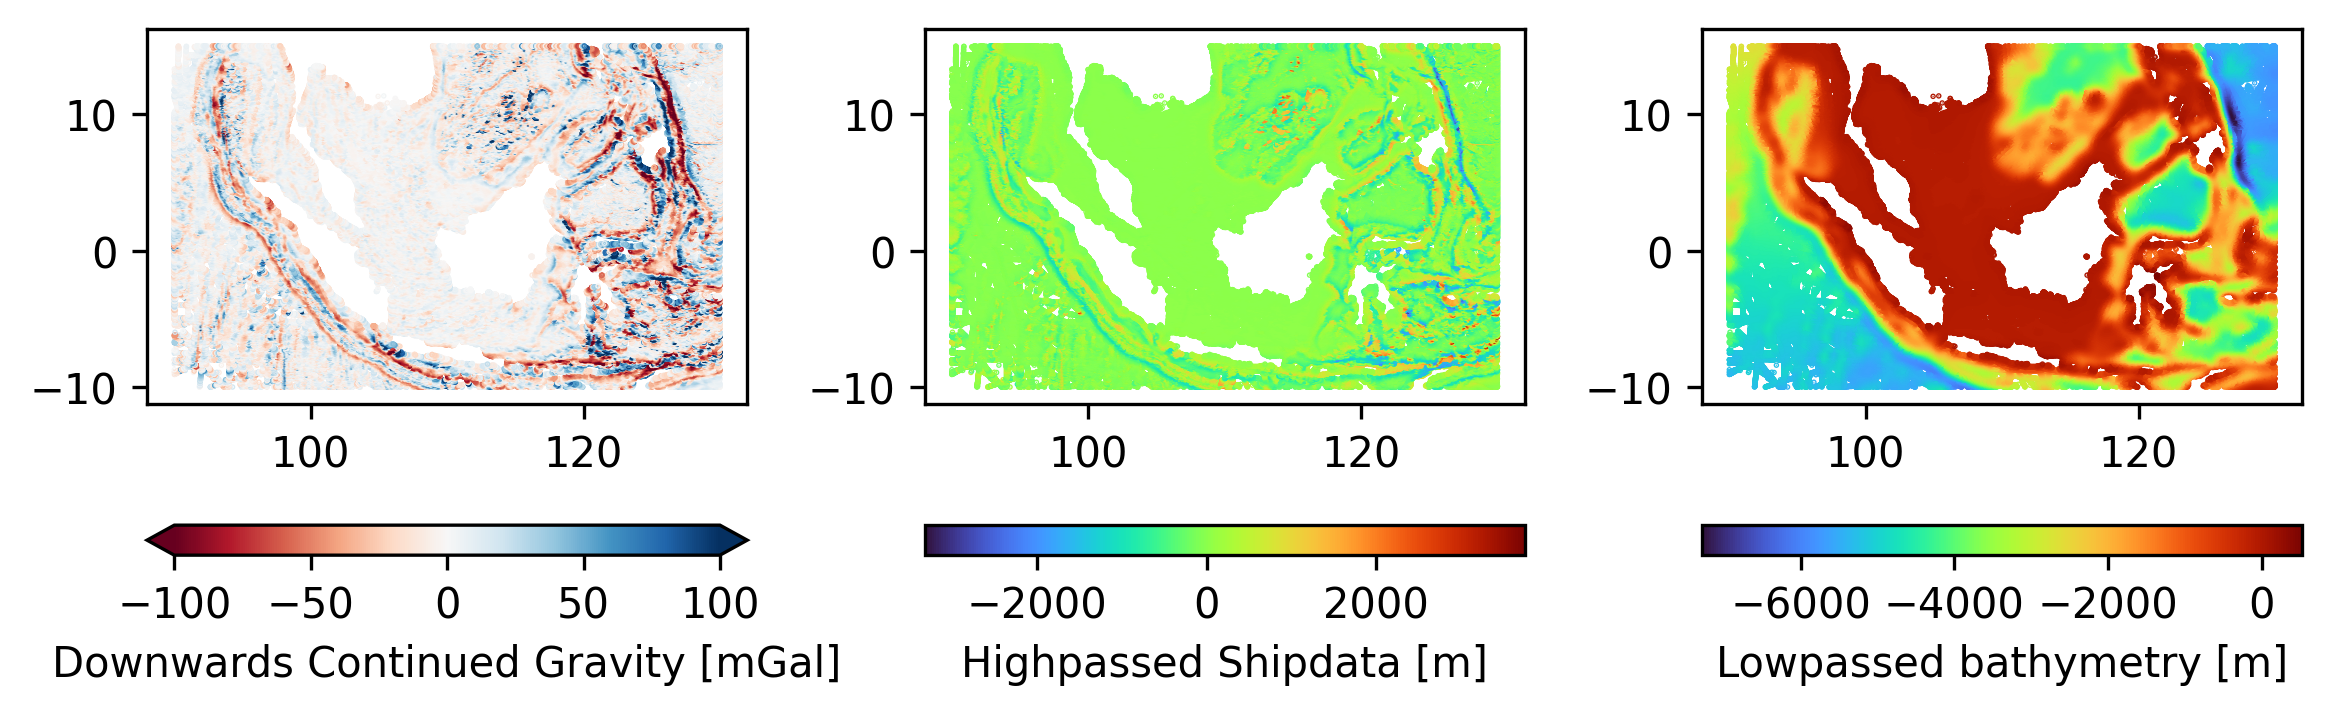

In [35]:
# Convert to column vectors
grav = grav.reshape(-1)
ship = ship.reshape(-1)
topo_low = topo_low.reshape(-1)
lat = lat.reshape(-1)
lon = lon.reshape(-1)

# Remove data with no shipdata
mask = ~np.isnan(ship)
grav = grav[mask]
ship = ship[mask]
topo_low = topo_low[mask]
lat = lat[mask]
lon = lon[mask]

print("N valid data: {}".format(lat.size))

# Plot data
cm = 1/2.54
fig = plt.figure(figsize=(20*cm, 8*cm), dpi=300)

ax = fig.add_subplot(1,3,1)
sc = ax.scatter(lon, lat, 0.1, grav, vmin=-100, vmax=100, cmap="RdBu")
ax.set_aspect(1)
plt.colorbar(sc, orientation="horizontal", label="Downwards Continued Gravity [mGal]", extend="both")

ax = fig.add_subplot(1,3,2)
sc = ax.scatter(lon, lat, 0.1, ship, cmap="turbo")
ax.set_aspect(1)
plt.colorbar(sc, orientation="horizontal", label="Highpassed Shipdata [m]")

ax = fig.add_subplot(1,3,3)
sc = ax.scatter(lon, lat, 0.1, topo_low, cmap="turbo")
ax.set_aspect(1)
plt.colorbar(sc, orientation="horizontal", label="Lowpassed bathymetry [m]")

plt.tight_layout()
plt.show()

There are 1024 groups. biggest - smallest = 817 - 816 = 1
Group_n 817


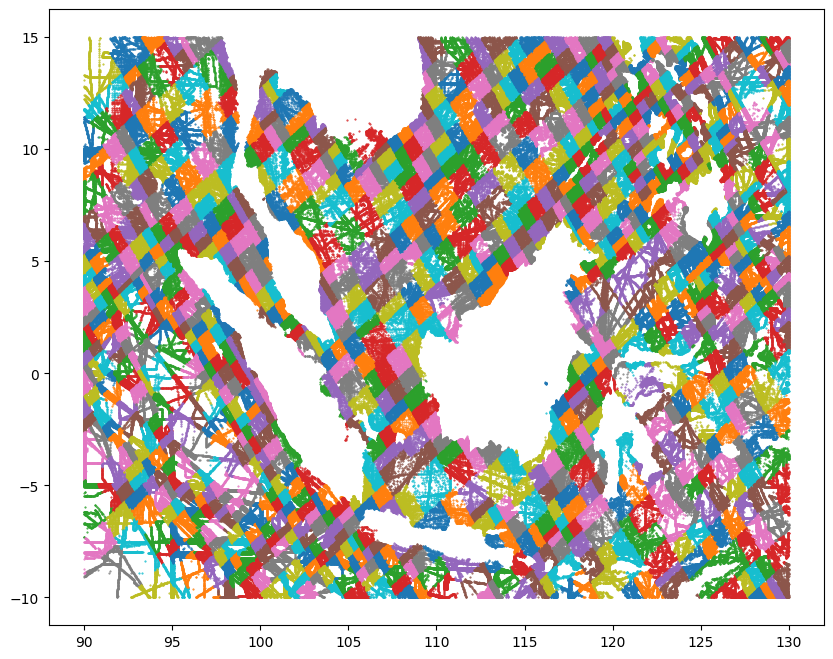

Using 816 in each tile
Data is grouped, lost 271 points without a group, corresponding to 0.0324%
Shape of output is (1024, 816, 5)


In [ ]:
# Group data in equal size groups
def group_data(lon, lat, groups=7):

    grouping_i = groups

    points = np.asarray(np.c_[lon, lat])
    # Setup rotation matrix
    deg = 45
    radians = np.degrees(deg)
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])

    # Generate KDTree with points rotated
    tree = cKDTree((j @ points.T).T,  balanced_tree=True)

    # Navigate KDTree
    groups = []
    def recurse(node, i=0):
        g = node.greater
        l = node.lesser
        if(i == grouping_i):
            groups.append([g.data_points,g.indices])
            groups.append([l.data_points, l.indices])
            return
        recurse(g, i=i+1)
        recurse(l, i=i+1)

    recurse(tree.tree)

    # Setup rotation matrix for -10°
    radians = np.degrees(-deg)
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])

    # Count the size of bins, rotate points back and plot bins.
    plt.figure(figsize=(10,8))
    list_len = []
    points_grouped = []
    vals_grouped = []
    for group, indices in groups:
        points_rot_ = (j @ group.T).T
        points_grouped.append(points_rot_)
        vals_grouped.append(indices)
        list_len.append(len(group))
        plt.plot(points_rot_[:, 0], points_rot_[:, 1], 'o', markersize=0.5)
    print(f"There are {len(groups)} groups.", end=' ')
    print(f"biggest - smallest = {max(list_len)} - {min(list_len)} = {max(list_len) - min(list_len)}")

    group_n = min(list_len)
    print("Group_n", group_n)
    plt.show()

    # group the data
    grouped_data = []
    n_per_group = min(list_len)
    print("Using {} in each tile".format(n_per_group))
    for points_, vals_ in zip(points_grouped, vals_grouped):
        # group the data
        grouped_data.append(np.c_[points_[:n_per_group, 0], 
                                points_[:n_per_group, 1], 
                                grav[vals_][:n_per_group], 
                                topo_low[vals_][:n_per_group], 
                                ship[vals_][:n_per_group]])
    grouped_data = np.array(grouped_data)

    print("Data is grouped, lost {} points without a group, corresponding to {:.4f}%".format(ship.size - grouped_data[:,:,0].size, (ship.size - grouped_data[:,:,0].size)/ship.size*100))
    print("Shape of output is {}".format(grouped_data.shape))

    return grouped_data

grouped_data = group_data(lon, lat, groups=9)

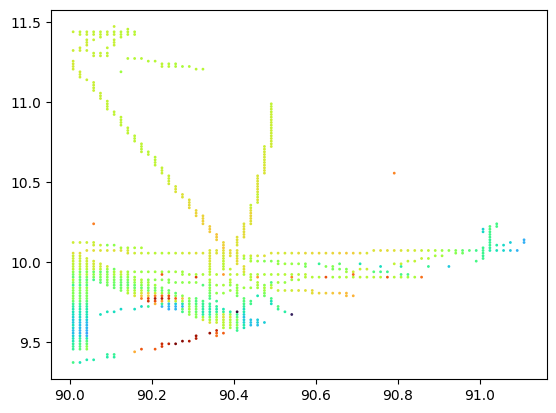

In [38]:
batch_id = 0
plt.scatter(grouped_data[batch_id,:,0], grouped_data[batch_id,:,1], 1, grouped_data[batch_id,:,4], cmap="turbo")

In [39]:
# Save data as "data" and "target"
np.save("../data/processed/data.npy", grouped_data[:,:,:4])
np.save("../data/processed/target.npy", grouped_data[:,:,4])